In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings(action='ignore') # Ignore warning message

import gc

In [4]:
# 변수 지정
df_cats = pd.read_csv('./input/competitive-data-science-predict-future-sales/item_categories.csv')
df_items = pd.read_csv('./input/competitive-data-science-predict-future-sales/items.csv')
df_train = pd.read_csv('./input/competitive-data-science-predict-future-sales/sales_train.csv')
df_shops = pd.read_csv('./input/competitive-data-science-predict-future-sales/shops.csv')
df_test = pd.read_csv('./input/competitive-data-science-predict-future-sales/test.csv')
df_submission = pd.read_csv('./input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [5]:
# 다운캐스트 함수 설정 
# 메모리를 효율적으로 사용하기 위해 함수 설정 
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [df_train, df_shops, df_items, df_cats, df_test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


In [6]:
# 0보다 작은 값들 제거 (가격)
df_train = df_train[df_train['item_price'] > 0]
# 50,000보다 큰 수치는 이상치로 판단하여 제거 (가격)
df_train = df_train[df_train['item_price'] < 50000]
# 0보다 작은 값들 제거 (판매수량)
df_train = df_train[df_train['item_cnt_day'] > 0]
# 1,000보다 큰 수치는 이상치로 판단하여 제거(판매량)
df_train = df_train[df_train['item_cnt_day'] < 1000]

In [7]:
# df_shops 에서 유사한 shop으로 보이나 표기가 잘못된것 같은 항목들 보여줌
print(df_shops['shop_name'][0], '||', df_shops['shop_name'][57])
print(df_shops['shop_name'][1], '||', df_shops['shop_name'][58])
print(df_shops['shop_name'][10], '||', df_shops['shop_name'][11])
print(df_shops['shop_name'][39], '||', df_shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [8]:
# df_train 데이터에서 위에 보여준 같은 수치의 shop들의 id 변경
df_train.loc[df_train['shop_id'] == 0, 'shop_id'] = 57
df_train.loc[df_train['shop_id'] == 1, 'shop_id'] = 58
df_train.loc[df_train['shop_id'] == 10, 'shop_id'] = 11
df_train.loc[df_train['shop_id'] == 39, 'shop_id'] = 40

#  df_test 데이터에서 위에 보여준 같은 수치의 shop들의 id 변경
df_test.loc[df_test['shop_id'] == 0, 'shop_id'] = 57
df_test.loc[df_test['shop_id'] == 1, 'shop_id'] = 58
df_test.loc[df_test['shop_id'] == 10, 'shop_id'] = 11
df_test.loc[df_test['shop_id'] == 39, 'shop_id'] = 40

In [8]:
# df_test 데이터에서 없는 shop_id는 df_train 에서 필요가 없기 때문에 제거
unique_test_shop_id = df_test['shop_id'].unique()
df_train = df_train[df_train['shop_id'].isin(unique_test_shop_id)]

#### shops_preprocessing

In [9]:
# df_shops 에서 잘못 표기된 이름 변경 
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

# df_shops 에서 앞단어가 city로 표기됨을 확인 해서 분리해주는 과정 
df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops['category'] = df_shops['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

# !가들어가고 잘못 표기된 도시명 변경
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

# category에 들어가는 항목들 제외하고는 수치가 적기때문에 etc로 설정
category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
df_shops.category = df_shops.category.apply(lambda x: x if (x in category) else 'etc')
df_shops.category.unique()

df_shops.groupby(['category']).sum()

,shop_id
category,
etc,68.0
Магазин,22.0
"Орджоникидзе,",57.0
ТК,184.0
ТРК,140.0
ТРЦ,340.0
ТЦ,883.0
склад,55.0
ул.,21.0


In [10]:
# df를 확인 결과 category를 제외한 나머지 수치도 적기 때문에 etc로 추가 변경 
category = ['ТК', 'ТРК', 'ТРЦ', 'ТЦ']
df_shops.category = df_shops.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', df_shops.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc         223.0
ТК          184.0
ТРК         140.0
ТРЦ         340.0
ТЦ          883.0


In [11]:
df_shops['shop_city'] = df_shops.city
df_shops['shop_category'] = df_shops.category

# df_shops 에서 city와 category 항목을 라벨인코더를 통하여 수치화로 변경
df_shops['shop_city'] = LabelEncoder().fit_transform(df_shops['shop_city'])
df_shops['shop_category'] = LabelEncoder().fit_transform(df_shops['shop_category'])

# df_shops 를 shop_id , shop_city, shop_category로 뽑아서 df_shops 전처리 마무리
df_shops = df_shops[['shop_id','shop_city','shop_category']]
df_shops.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


#### item_preprocessing

In [12]:
# 정규표현식 
from collections import Counter
from operator import itemgetter

# items를 확인해보면 [ ] ,( ) 들어가서 분리가 되는 경우가 많기 때문에 첫번째 [ 와 ( 를 기준으로 
# name_1 ,name_2 ,name_3 으로 분류
df_items['name_1'], df_items['name_2'] = df_items['item_name'].str.split('[', 1).str
df_items['name_1'], df_items['name_3'] = df_items['item_name'].str.split('(', 1).str

# 영문자 소문자 숫자 러시아어로만 구성된 문자를 공백으로 처리 
df_items['name_2'] = df_items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
df_items['name_3'] = df_items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
df_items = df_items.fillna('0')

result_1 = Counter(' '.join(df_items['name_2'].values.tolist()).split(' ')).items() # 키와 값들의 쌍을 얻을 수 있는 함수
result_1 = sorted(result_1, key=itemgetter(1)) # itemgetter(1) 0이면 key, 1이면 value 로 정렬
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)] # 논의사항1

result_2 = Counter(' '.join(df_items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


In [13]:
# xbox내용이 내용이 많아서 앞부분 split 파트가 xbox가 들어가면 전부 xbox로 처리 
df_items['type'] = df_items.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
df_items['type'].unique()

array(['0', 'pc', 'ps3', 'pс', 'xbox 360', 'цифровая', '', 'p', 'mac',
       'psp', 'рs3', 'ps4', 'xbox one', 'x360', 'ps', 'xbox360',
       'русская', 'рс', 'android', 'англ', 'ps2', 'только', 'цифров',
       '6jv', 'j72', 'hm3', 's3v', '6dv', '6l6', '5f4', 's4v', 'kg4',
       '5c5', '5c7', 'kf7', 'kf6'], dtype=object)

In [14]:
# item 종류 세분화 
df_items.loc[(df_items.type == 'x360') | (df_items.type == 'xbox360'), 'type'] = 'xbox 360'
df_items.loc[df_items.type == '', 'type'] = 'mac'
df_items.type = df_items.type.apply(lambda x: x.replace(' ',''))
df_items.loc[(df_items.type == 'pc')|(df_items.type == 'pс')|(df_items.type == 'рс'), 'type'] = 'pc'
df_items.loc[(df_items.type == 'рs3'), 'type'] = 'ps3'

In [15]:
group_sum = df_items.groupby('type').sum()
group_sum.head()

,item_id,item_category_id
type,,
0,218310960.0,872182.0
5c5,12118.0,16.0
5c7,26808.0,32.0
5f4,7936.0,7.0
6dv,7934.0,7.0


In [16]:
# 분리한 category 에서 200개보다 아래인 항목들을 etc처리하기위해 뽑아냄 
group_sum.loc[group_sum.item_category_id < 200]

,item_id,item_category_id
type,,
5c5,12118.0,16.0
5c7,26808.0,32.0
5f4,7936.0,7.0
6dv,7934.0,7.0
6jv,7924.0,7.0
6l6,7935.0,7.0
android,12994.0,78.0
hm3,7926.0,7.0
j72,31709.0,28.0


In [17]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

# 큰 비중이 없는 항목들 etc로 처리 
df_items.name_2 = df_items.type.apply(lambda x: 'etc' if x in drop_list else x)
df_items = df_items.drop(['type'], axis=1)
df_items.groupby('name_2').sum()

,item_id,item_category_id
name_2,,
0,218310960.0,872182.0
etc,249594.0,496.0
mac,148022.0,2245.0
p,721.0,78.0
pc,16991083.0,106924.0
ps,431537.0,1738.0
ps3,3531772.0,11422.0
ps4,895981.0,3489.0
psp,692947.0,2415.0


In [18]:
# 문자를 라벨인코딩으로 수치화 한후 수치화된 값들만 남기고 나머지 항목은 제거 
df_items['name_2'] = LabelEncoder().fit_transform(df_items['name_2'])
df_items['name_3'] = LabelEncoder().fit_transform(df_items['name_3'])
df_items.drop(['item_name','name_1'], axis=1, inplace=True)
df_items.head()

,item_id,item_category_id,name_2,name_3
0,0,40,0,1331
1,1,76,4,42
2,2,40,0,1011
3,3,40,0,1010
4,4,40,0,1572


In [19]:
# first_sale_date 라는 새로운 column 생성 
df_items['first_sale_date'] = df_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

df_items.head()

,item_id,item_category_id,name_2,name_3,first_sale_date
0,0,40,0,1331,20.0
1,1,76,4,42,15.0
2,2,40,0,1011,19.0
3,3,40,0,1010,18.0
4,4,40,0,1572,20.0


In [20]:
# nan 값 확인 
df_items[df_items['first_sale_date'].isna()]

,item_id,item_category_id,name_2,name_3,first_sale_date
0,0,40,0,1331,NaN
2,2,40,0,1011,NaN
3,3,40,0,1010,NaN
4,4,40,0,1572,NaN
5,5,40,0,1008,NaN
...,...,...,...,...,...
21975,21975,61,0,42,NaN
22022,22022,40,0,952,NaN
22028,22028,40,0,42,NaN
22035,22035,40,0,42,NaN


In [25]:
# nan값을 34로 채워준다 
df_items['first_sale_date'] = df_items['first_sale_date'].fillna(34)

In [26]:
df_items.head()

,item_id,item_category_id,name_2,name_3,first_sale_date
0,0,40,0,1331,20.0
1,1,76,4,42,15.0
2,2,40,0,1011,19.0
3,3,40,0,1010,18.0
4,4,40,0,1572,20.0


#### category preprocessing

In [27]:
df_cats.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [28]:
# category_name을 split 함수를 사용해서 앞부분과 뒷부분으로 분리 
df_cats['type_code'] = df_cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
df_cats.loc[(df_cats.type_code == 'Игровые') | (df_cats.type_code == 'Аксессуары'), 'category'] = 'Игры'
df_cats.loc[df_cats.type_code == 'PC', 'category'] = 'Музыка'

# 주요 항목들을 category에 설정 한 후 나머지 항목들은 etc로 바꿔줌
category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']
df_cats['type_code'] = df_cats.type_code.apply(lambda x: x if (x in category) else 'etc')

print(df_cats.groupby(['type_code']).sum())

           item_category_id
type_code                  
etc                   236.0
Игры                  343.0
Карты                 170.0
Кино                  195.0
Книги                 624.0
Музыка                345.0
Подарки               798.0
Программы             453.0
Служебные             159.0
Чистые                163.0


In [29]:
# 라벨 인코더로 수치화 
df_cats['type_code'] = LabelEncoder().fit_transform(df_cats['type_code'])
df_cats.head()

,item_category_name,item_category_id,type_code,category
0,PC - Гарнитуры/Наушники,0,0,Музыка
1,Аксессуары - PS2,1,0,Игры
2,Аксессуары - PS3,2,0,Игры
3,Аксессуары - PS4,3,0,Игры
4,Аксессуары - PSP,4,0,Игры


In [30]:
# category_name을 다시 split 하여 세부 항목 생성
df_cats['split'] = df_cats.item_category_name.apply(lambda x: x.split('-'))
df_cats['subtype'] = df_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_cats['subtype_code'] = LabelEncoder().fit_transform(df_cats['subtype'])
df_cats = df_cats[['item_category_id', 'type_code', 'subtype_code']]

In [31]:
df_cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,0,9
2,2,0,10
3,3,0,11
4,4,0,13


In [32]:
df_items.head()

,item_id,item_category_id,name_2,name_3,first_sale_date
0,0,40,0,1331,20.0
1,1,76,4,42,15.0
2,2,40,0,1011,19.0
3,3,40,0,1010,18.0
4,4,40,0,1572,20.0


In [33]:
df_shops.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


In [34]:
from itertools import product

train = []
# date_block_num, shop_id, item_id 전부 들어간 새로운 데이터프레임 형성 
for i in df_train['date_block_num'].unique():
    all_shop = df_train.loc[df_train['date_block_num']==i, 'shop_id'].unique()
    all_item = df_train.loc[df_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [35]:
#  groupby를 사용하여서 item_cnt_day의 합과, item_price의 평균을 구하여서 
#  item_cnt_month, item_price_mean feature 생성
group = df_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [36]:
# group 제거 후 메모리 회수하여 최적화 
del group
gc.collect();

In [33]:
# groupby 를 사용하여서 item_count (아이템 판매수량) feature 생성
group = df_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# group 제거후 메모리 회수 
del group
gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


In [34]:
# test에 date_block_num 항목 추가후 34입력 
df_test['date_block_num'] = 34

# train과 test를 concat하여 all_data 새로운 데이터프레임 생성
all_data = pd.concat([train, df_test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# NaN값 0으로 처리
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [35]:
df_cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,0,9
2,2,0,10
3,3,0,11
4,4,0,13


In [36]:
# all_data 에 shops, items, cats 데이터프레임 merge
all_data = all_data.merge(df_shops, on='shop_id', how='left')
all_data = all_data.merge(df_items, on='item_id', how='left')
all_data = all_data.merge(df_cats, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del df_shops, df_items, df_cats
gc.collect();

61.6% compressed


In [37]:
# all_data에 전반적인 분석을 하는 함수 
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [38]:
resumetable(all_data)

Data Shape: (8856961, 14)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int8,0,35,0.0,0.0,0.0
shop_id,int8,0,42,59.0,59.0,59.0
item_id,int16,0,21464,22154.0,2552.0,2554.0
item_cnt_month,int16,0,407,1.0,0.0,0.0
item_price_mean,float32,0,34147,999.0,0.0,0.0
item_count,int8,0,40,1.0,0.0,0.0
shop_city,int8,0,28,30.0,30.0,30.0
shop_category,int8,0,5,4.0,4.0,4.0
item_category_id,int8,0,84,37.0,58.0,58.0
name_2,int8,0,13,0.0,0.0,0.0


#### Visualization

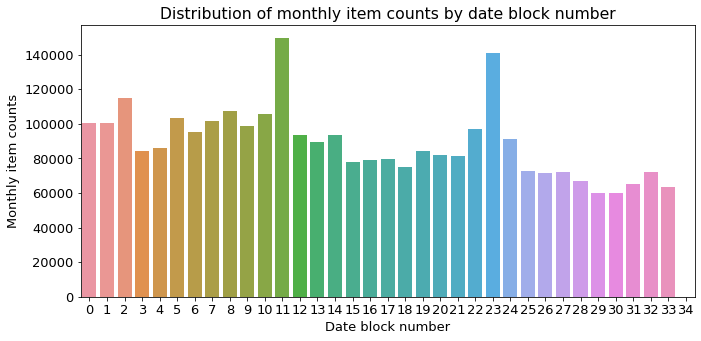

In [39]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = all_data.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

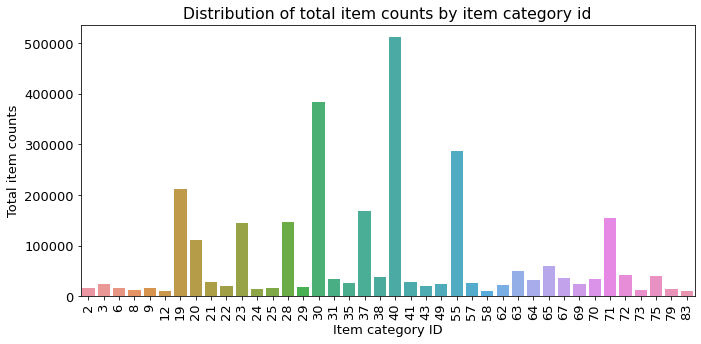

In [40]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = all_data.groupby('item_category_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='item_category_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

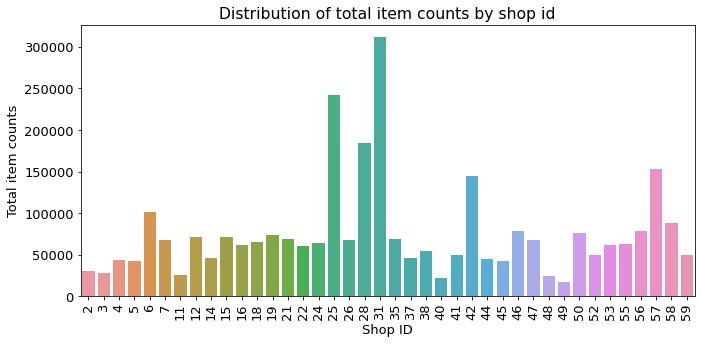

In [41]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = all_data.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

#### Create lags features

In [42]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features , asssert 이후의 조건에 맞지 않으면 에러 발생
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # feature_name 생성 len(idx_feature)가 2와 3일때 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # 월별 평균 판매량을 feature_name 으로 새로운 feature 생성 
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # 만들어진 group을 함수에 들어가는 df와 merge
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # mean_feautres 라는 리스트에 새롭게 생성된 feature 확인하기위해 append 해줌
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [43]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []

# item_id_mean_sales라는 feature(월별 평균 판매량) 생성 
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# item_id_shop_city_mean_sales라는 feature(월별 평균 판매량) 생성 
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'shop_city'])

In [44]:
item_mean_features

['item_id_mean_sales', 'item_id_shop_city_mean_sales']

In [45]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# shop_id_item_category_id_mean_sales라는 feature(월별 평균 판매량) 생성 
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [46]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [47]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# 위에서 설명한 add_lag_features 함수를 통하여 lag feature 3개 생성 
all_data, lag_features_to_clip = add_lag_features(all_data, lag_features_to_clip, idx_features, 'item_cnt_month', [1, 2, 3], True, True)

In [48]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
item_price_mean,999.000000,0.000000,0.000000,0.000000,0.000000
item_count,1.000000,0.000000,0.000000,0.000000,0.000000
shop_city,30.000000,30.000000,30.000000,30.000000,30.000000
shop_category,4.000000,4.000000,4.000000,4.000000,4.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
name_2,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
# all_data.drop(columns='item_id_mean_sales_y', axis=1, inplace=True)

In [50]:
all_data.rename(columns={'item_id_mean_sales_x':'item_id_mean_sales'}, inplace=True)

In [51]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
item_price_mean,999.000000,0.000000,0.000000,0.000000,0.000000
item_count,1.000000,0.000000,0.000000,0.000000,0.000000
shop_city,30.000000,30.000000,30.000000,30.000000,30.000000
shop_category,4.000000,4.000000,4.000000,4.000000,4.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
name_2,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
lag_features_to_clip

['item_cnt_month_lag1', 'item_cnt_month_lag2', 'item_cnt_month_lag3']

In [2]:
def add_lag_features(df, lag_features_to_clip, idx_features, lag_feature, nlags=3, clip=False, accum=True):
     # Copy only the part of the DataFrame needed to create the lag features
    if accum:
        df_temp = df[idx_features + [lag_feature]].copy() 

        # Create lag features
        for i in nlags:
              # Lag featrue name
            lag_feature_name = lag_feature +'_lag' + str(i)
                # Set df_temp column name
            df_temp.columns = idx_features + [lag_feature_name]
                    # Add 1 to date_block_num feature in df_temp
            df_temp['date_block_num'] += i
                    # Merge df with df_temp based on idx_feature
            df = df.merge(df_temp.drop_duplicates(), on=idx_features, how='left')
                    # Replace NaN with 0
            df[lag_feature_name] = df[lag_feature_name].fillna(0)
                    # Add lag features to lag_features_to_clip to clip between 0 and 20
            if clip: 
                lag_features_to_clip.append(lag_feature_name)

            # Date downcasting
        df = downcast(df, False)
            # Garbage collection
        del df_temp
        gc.collect()

        return df, lag_features_to_clip
    
    else:
        tmp = df[['date_block_num','shop_id','item_id',lag_feature]]
        for i in nlags:
            shifted = tmp.copy()  # for문 안에서 돌 때마다 새로운 copy를 찍어내기 때문에 누적합(+=i)이 되지 않음.
            shifted.columns = ['date_block_num', 'shop_id', 'item_id', lag_feature+'_lag_'+str(i)]
            shifted['date_block_num'] += i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')

        downcast(df, False)
        return df

In [53]:
# item_count의 lag feature 3개 생성 
all_data, lag_features_to_clip = add_lag_features(all_data, lag_features_to_clip, idx_features,'item_count', [1, 2, 3], False, True)

# item_price_mean의 lag feature 3개 생성
all_data, lag_features_to_clip = add_lag_features(all_data, lag_features_to_clip, idx_features, 'item_price_mean', [1, 2, 3], False, True)

In [54]:
X_test_temp = all_data[all_data['date_block_num'] == 34]
X_test_temp[item_mean_features].sum()

item_id_mean_sales              0.0
item_id_shop_city_mean_sales    0.0
dtype: float32

In [55]:
# # item_id_mean_sales 과 item_id_shop_city_mean_sales의 lag feature 3개 생성 
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(all_data, lag_features_to_clip, idx_features, item_mean_feature, [1, 2, 3], False, True)

# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

In [56]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [57]:
# shop_id_item_category_id_mean_sales의 lag feature 3개 생성 
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(all_data, lag_features_to_clip, ['date_block_num', 'shop_id', 'item_category_id'], shop_mean_feature, [1, 2, 3], False, True)

# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [58]:
# lag feature를 3개로 잡았기 때문에 앞에 3개 date_bloock_num 제거
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

In [59]:
all_data.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,shop_city,shop_category,item_category_id,name_2,...,item_price_mean_lag3,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_shop_city_mean_sales_lag1,item_id_shop_city_mean_sales_lag2,item_id_shop_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3
827196,3,25,8092,3,149.0,3,13,2,40,0,...,0.0,0.666667,1.428571,0.0,1.000000,2.142857,0.0,1.087262,1.049296,0.0
827197,3,25,7850,3,199.0,3,13,2,30,4,...,0.0,2.000000,3.114286,0.0,3.714286,2.285714,0.0,3.654494,2.279188,0.0
827198,3,25,8051,3,30.0,2,13,2,66,0,...,0.0,0.027778,0.085714,0.0,0.000000,0.428571,0.0,1.827586,1.389474,0.0


In [60]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1
5,10.01.2013,0,25,2564,349.000000,1


In [61]:
# 월별, shop_id, subtype_code별 판매수량 평균
group = all_data.groupby(['date_block_num','shop_id','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,subtype_code,date_shop_subtype_avg_item_cnt
0,3,2,0,0.500000
1,3,2,1,0.038882
2,3,2,2,0.006289
3,3,2,3,0.000000
4,3,2,4,0.019912


In [62]:
all_data = pd.merge(all_data,group, on=['date_block_num','shop_id','subtype_code'], how='left')
all_data['date_shop_subtype_avg_item_cnt'] = all_data['date_shop_subtype_avg_item_cnt'].astype(np.float16)
all_data = add_lag_features(all_data, lag_features_to_clip, idx_features, 'date_shop_subtype_avg_item_cnt', [1, 2, 3], False, False)
all_data.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [63]:
all_data.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,shop_city,shop_category,item_category_id,name_2,...,item_id_mean_sales_lag3,item_id_shop_city_mean_sales_lag1,item_id_shop_city_mean_sales_lag2,item_id_shop_city_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_3
0,3,25,8092,3,149.0,3,13,2,40,0,...,0.0,1.000000,2.142857,0.0,1.087262,1.049296,0.0,NaN,NaN,NaN
1,3,25,7850,3,199.0,3,13,2,30,4,...,0.0,3.714286,2.285714,0.0,3.654494,2.279188,0.0,NaN,NaN,NaN
2,3,25,8051,3,30.0,2,13,2,66,0,...,0.0,0.000000,0.428571,0.0,1.827586,1.389474,0.0,NaN,NaN,NaN


In [64]:
# group = all_data.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
# group.columns = ['date_item_city_avg_item_cnt']
# group.reset_index(inplace=True)

# all_data = pd.merge(all_data, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
# all_data['date_item_city_avg_item_cnt'] = all_data['date_item_city_avg_item_cnt'].astype(np.float16)
# all_data = add_lag_features(all_data, [1], 'date_item_city_avg_item_cnt')
# all_data.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [65]:
# 월별 , shop_id, item_id별 판매수량 평균 
group = all_data.groupby(['date_block_num','shop_id' ,'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_item_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','shop_id' ,'item_id'], how='left')
all_data['date_shop_item_avg_item_cnt'] = all_data['date_shop_item_avg_item_cnt'].astype(np.float16)
all_data = add_lag_features(all_data, lag_features_to_clip, idx_features, 'date_shop_item_avg_item_cnt', [1, 2, 3], False, False)
all_data.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)

In [66]:
# item_id별 판매량 평균 
group = df_train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

all_data = pd.merge(all_data,group, on=['item_id'], how='left')
all_data['item_avg_item_price'] = all_data['item_avg_item_price'].astype(np.float16)

group = df_train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

all_data = pd.merge(all_data,group, on=['date_block_num','item_id'], how='left')
all_data['date_item_avg_item_price'] = all_data['date_item_avg_item_price'].astype(np.float16)

In [67]:
all_data = add_lag_features(all_data, lag_features_to_clip, idx_features, 'date_item_avg_item_price', [1,2,3,4,5,6,9,10,11,12], False, False)

In [68]:
all_data.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,shop_city,shop_category,item_category_id,name_2,...,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_item_avg_item_price_lag_9,date_item_avg_item_price_lag_10,date_item_avg_item_price_lag_11,date_item_avg_item_price_lag_12
0,3,25,8092,3,149.0,3,13,2,40,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,25,7850,3,199.0,3,13,2,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,25,8051,3,30.0,2,13,2,66,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'shop_city', 'shop_category',
       'item_category_id', 'name_2', 'name_3', 'first_sale_date', 'type_code',
       'subtype_code', 'item_cnt_month_lag1', 'item_cnt_month_lag2',
       'item_cnt_month_lag3', 'item_count_lag1', 'item_count_lag2',
       'item_count_lag3', 'item_price_mean_lag1', 'item_price_mean_lag2',
       'item_price_mean_lag3', 'item_id_mean_sales_lag1',
       'item_id_mean_sales_lag2', 'item_id_mean_sales_lag3',
       'item_id_shop_city_mean_sales_lag1',
       'item_id_shop_city_mean_sales_lag2',
       'item_id_shop_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3',
       'date_shop_item_avg_ite

In [70]:
# all_data.drop(columns=['delta_price_lag','date_item_avg_item_price_y','item_avg_item_price_x','item_avg_item_price_y'], axis=1, inplace=True)

In [71]:
# all_data.rename(columns={'date_item_avg_item_price_x':'date_item_avg_item_price'}, inplace=True)

In [72]:
all_data.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,shop_city,shop_category,item_category_id,name_2,...,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_item_avg_item_price_lag_9,date_item_avg_item_price_lag_10,date_item_avg_item_price_lag_11,date_item_avg_item_price_lag_12
0,3,25,8092,3,149.0,3,13,2,40,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,25,7850,3,199.0,3,13,2,30,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,25,8051,3,30.0,2,13,2,66,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# all_data.drop(columns='date_item_avg_item_price_y', axis=1, inplace=True)

In [74]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'shop_city', 'shop_category',
       'item_category_id', 'name_2', 'name_3', 'first_sale_date', 'type_code',
       'subtype_code', 'item_cnt_month_lag1', 'item_cnt_month_lag2',
       'item_cnt_month_lag3', 'item_count_lag1', 'item_count_lag2',
       'item_count_lag3', 'item_price_mean_lag1', 'item_price_mean_lag2',
       'item_price_mean_lag3', 'item_id_mean_sales_lag1',
       'item_id_mean_sales_lag2', 'item_id_mean_sales_lag3',
       'item_id_shop_city_mean_sales_lag1',
       'item_id_shop_city_mean_sales_lag2',
       'item_id_shop_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3',
       'date_shop_item_avg_ite

In [75]:
# all_data.rename(columns={'date_item_avg_item_price_x':'data_item_avg_item_price'}, inplace=True)

In [76]:
# all_data.head(1)

In [77]:
# all_data.head(1)

In [78]:
# all_data.head(1)

In [79]:
# all_data.drop(columns=['date_item_avg_item_price_lag_1_y','date_item_avg_item_price_lag_2_y','date_item_avg_item_price_lag_3_y'],axis=1,inplace=True)

In [80]:
# all_data.rename(columns={'date_item_avg_item_price_lag_1_x':'date_item_avg_item_price_lag_1'},inplace=True)

In [81]:
# all_data.rename(columns={'date_item_avg_item_price_lag_2_x':'date_item_avg_item_price_lag_2'},inplace=True)

In [82]:
# all_data.rename(columns={'date_item_avg_item_price_lag_3_x':'date_item_avg_item_price_lag_3'},inplace=True)

In [83]:
#all_data.columns

In [84]:
# 몇 퍼 증가, 혹은 몇 퍼 하락했는지 알기 위해 >>> 추세
lags = [1,2,3,4,5,6,9,10,11,12]

for i in lags:
    all_data['delta_price_lag_'+str(i)] = (all_data['date_item_avg_item_price_lag_'+str(i)] - all_data['item_avg_item_price']) / all_data['item_avg_item_price']
    
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
all_data['delta_price_lag'] = all_data.apply(select_trend, axis=1)
all_data['delta_price_lag'] = all_data['delta_price_lag'].astype(np.float16)
all_data['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

all_data.drop(fetures_to_drop, axis=1, inplace=True)

In [85]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'shop_city', 'shop_category',
       'item_category_id', 'name_2', 'name_3', 'first_sale_date', 'type_code',
       'subtype_code', 'item_cnt_month_lag1', 'item_cnt_month_lag2',
       'item_cnt_month_lag3', 'item_count_lag1', 'item_count_lag2',
       'item_count_lag3', 'item_price_mean_lag1', 'item_price_mean_lag2',
       'item_price_mean_lag3', 'item_id_mean_sales_lag1',
       'item_id_mean_sales_lag2', 'item_id_mean_sales_lag3',
       'item_id_shop_city_mean_sales_lag1',
       'item_id_shop_city_mean_sales_lag2',
       'item_id_shop_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3',
       'date_shop_item_avg_ite

In [86]:
# 가격 * 판매수량 = 수익량의 feature 생성 
df_train['revenue'] = df_train['item_price'] * df_train['item_cnt_day']

In [87]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.000000,1,999.000000
1,03.01.2013,0,25,2552,899.000000,1,899.000000
3,06.01.2013,0,25,2554,1709.050049,1,1709.050049
4,15.01.2013,0,25,2555,1099.000000,1,1099.000000
5,10.01.2013,0,25,2564,349.000000,1,349.000000


In [88]:
# 월별 shop의 수익 
group = df_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','shop_id'], how='left')
all_data['date_shop_revenue'] = all_data['date_shop_revenue'].astype(np.float32)

# shop별 월간 평균 수익
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['shop_id'], how='left')
all_data['shop_avg_revenue'] = all_data['shop_avg_revenue'].astype(np.float32)

# 수익에 대한 추세 생성 하여 lag feature 생성 
all_data['delta_revenue'] = (all_data['date_shop_revenue'] - all_data['shop_avg_revenue']) / all_data['shop_avg_revenue']
all_data['delta_revenue'] = all_data['delta_revenue'].astype(np.float16)

all_data = add_lag_features(all_data, lag_features_to_clip, idx_features, 'delta_revenue', [1,2,3,6,12], False, False)

all_data.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [89]:
all_data['month'] = all_data['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days).astype(np.int8)

In [90]:
#all_data.info()

In [91]:
# item_cnt_month_lag들에 대한 평균 feature 생성 
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)

In [92]:
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)

In [93]:
all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [94]:
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']

In [95]:
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

In [96]:
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029765 entries, 0 to 8029764
Data columns (total 48 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int8   
 4   shop_city                                 int8   
 5   shop_category                             int8   
 6   item_category_id                          int8   
 7   name_2                                    int8   
 8   name_3                                    int16  
 9   type_code                                 int8   
 10  subtype_code                              int8   
 11  item_cnt_month_lag1                       int8   
 12  item_cnt_month_lag2                       int8   
 13  item_cnt_month_lag3                       int8   
 14  it

In [97]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
del all_data
gc.collect();

In [98]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',                # evaluated set의 evaluate metric, rmse 사용
          'num_leaves': 255,               # 전체 트리의 잎 수 , 기본값 31개
          'learning_rate': 0.005,          # 각 트리가 최종 결과에 미치는 영향을 결정
          'feature_fraction': 0.75,        # 부스팅이 랜덤 포레스트일 때 사용 반복하여 75% 파라미터를 무작위로 선택하여 트리생성
          'bagging_fraction': 0.75,        # 각 반복에 사용할 데이터의 비율을 지정하여 traing 속도를 높이고 과적합 방지
          'bagging_freq': 5,               # 과적합 방지에 사용
          'force_col_wise' : True,         # 불안정성 방지를 위해 설정 column 값이 크거나 total number of bins가 클 경우 사용
          'random_state': 10}              # 랜덤 시드 고정값

cat_features = ['shop_id', 'shop_city', 'item_category_id', 'shop_category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)     

[LightGBM] [Info] Total Bins 6693
[LightGBM] [Info] Number of data points in the train set: 7593847, number of used features: 47
[LightGBM] [Info] Start training from score 0.307756
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01579	valid_1's rmse: 0.914376
[200]	training's rmse: 0.908752	valid_1's rmse: 0.843078
[300]	training's rmse: 0.85386	valid_1's rmse: 0.815058
[400]	training's rmse: 0.823693	valid_1's rmse: 0.804168
[500]	training's rmse: 0.803702	valid_1's rmse: 0.80037
[600]	training's rmse: 0.789844	valid_1's rmse: 0.799092
[700]	training's rmse: 0.779086	valid_1's rmse: 0.797593
[800]	training's rmse: 0.770047	valid_1's rmse: 0.797111
[900]	training's rmse: 0.762662	valid_1's rmse: 0.796956
[1000]	training's rmse: 0.75616	valid_1's rmse: 0.796909
[1100]	training's rmse: 0.750796	valid_1's rmse: 0.796727
[1200]	training's rmse: 0.746307	valid_1's rmse: 0.796513
[1300]	training's rmse: 0.742163	valid_1's rmse: 0.796383
[1400]	training

In [99]:
preds = lgb_model.predict(X_test).clip(0,20)

df_submission['item_cnt_month'] = preds
df_submission.to_csv('submission-6.csv', index=False)

In [100]:
# model = XGBRegressor(
#     max_depth=10,         # 트리의 깊이
#     n_estimators=1000,    # 반복횟수
#     min_child_weight=0.5, # 트리에서 추가적으로 가지를 나누는 여부의 데이터 weight 총합 (과적합제어)
#     colsample_bytree=0.8, # 트리 생성에 필요한 feature의 임의 생성에 사용 feauture가 많을 때 과적합조정에 사용
#     subsample=0.8,        # 과적합 방지로 데이터 샘플링의 비율 설정
#     eta=0.1,              # 학습률 설정 (0~1설졍, 보통 0.01~0.2사이 선호)
#     tree_method='hist',   # 사용할 tree 모델 
#     seed=42)

# model.fit(
#     X_train, 
#     y_train, 
#     eval_metric="rmse",                                   # 평가 세트에 적용할 성능 평가 방법
#     eval_set=[(X_train, y_train), (X_valid, y_valid)],    # 성능 평가를 수행할 평가용 데이터셋
#     verbose=True,                                         # 학습마다 평가값들에 대한 메세지를 출력 여부
#     early_stopping_rounds = 20)                           # 조기 종료 파라미터

In [101]:
# y_pred = model.predict(X_valid).clip(0, 20)
# y_test = model.predict(X_test).clip(0, 20)

# submission = pd.DataFrame({
#     "ID": df_test.index, 
#     "item_cnt_month": y_test
# })
# submission.to_csv('xgb_submission(4).csv', index=False)

# # save predictions for an ensemble
# pickle.dump(y_pred, open('xgb_train.pickle', 'wb'))
# pickle.dump(y_test, open('xgb_test.pickle', 'wb'))

In [102]:
# from xgboost import plot_importance

# def plot_features(booster, figsize):    
#     fig, ax = plt.subplots(1,1,figsize=figsize)
#     return plot_importance(booster=booster, ax=ax)

# plot_features(model, (10,14))